In [1]:
import argparse
import functools
import gc
import itertools
import json
import logging
import math
import os
import random
import shutil
from pathlib import Path
from easydict import EasyDict

In [2]:
import accelerate
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import transformers
import webdataset as wds
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from braceexpand import braceexpand
from huggingface_hub import create_repo
from packaging import version
#different
from torch.utils.data.dataloader import default_collate
#
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, CLIPTextModel, PretrainedConfig
from webdataset.tariterators import (
    base_plus_ext,
    tar_file_expander,
    url_opener,
    valid_sample,
)

In [3]:
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    LCMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import resolve_interpolation_mode
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from utils import update_ema, import_model_class_from_model_name_or_path, parse_args
from typing import List, Optional, Tuple, Union

In [4]:
from utils_ccdm import GradualWarmupScheduler
from models.engine import ConditionalGaussianDiffusionTrainer, ConditionalDiffusionEncoderTrainer, DDIMSampler, DDIMSamplerEncoder

In [5]:
import os
os.getcwd()

'/home/bobo/LCMSenv'

In [6]:
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 5.0


In [10]:
wandb

<module 'wandb' from '/home/bobo/LCMSenv/lib/python3.8/site-packages/wandb/__init__.py'>

In [9]:
MAX_SEQ_LENGTH = 77

import wandb
# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.18.0.dev0")
logger = get_logger(__name__)

In [25]:
# From LCMScheduler.get_scalings_for_boundary_condition_discrete
def scalings_for_boundary_conditions(timestep, sigma_data=0.5, timestep_scaling=10.0):
    scaled_timestep = timestep_scaling * timestep
    c_skip = sigma_data**2 / (scaled_timestep**2 + sigma_data**2)
    c_out = scaled_timestep / (scaled_timestep**2 + sigma_data**2) ** 0.5
    return c_skip, c_out

# Compare LCMScheduler.step, Step 4
def predicted_origin(model_output, timesteps, sample, prediction_type, alphas, sigmas):
    if prediction_type == "epsilon":
        sigmas = extract_into_tensor(sigmas, timesteps, sample.shape)
        alphas = extract_into_tensor(alphas, timesteps, sample.shape)
        pred_x_0 = (sample - sigmas * model_output) / alphas
    elif prediction_type == "v_prediction":
        sigmas = extract_into_tensor(sigmas, timesteps, sample.shape)
        alphas = extract_into_tensor(alphas, timesteps, sample.shape)
        pred_x_0 = alphas * sample - sigmas * model_output
    else:
        raise ValueError(f"Prediction type {prediction_type} currently not supported.")
    return pred_x_0

def extract_into_tensor(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

## DDIM solver

In [5]:
class DDIMSolver:
    def __init__(self, alpha_cumprods, timesteps=1000, ddim_timesteps=50):
        # DDIM sampling parameters
        step_ratio = timesteps // ddim_timesteps
        self.ddim_timesteps = (np.arange(1, ddim_timesteps + 1) * step_ratio).round().astype(np.int64) - 1
        self.ddim_alpha_cumprods = alpha_cumprods[self.ddim_timesteps]
        self.ddim_alpha_cumprods_prev = np.asarray(
            [alpha_cumprods[0]] + alpha_cumprods[self.ddim_timesteps[:-1]].tolist()
        )
        # convert to torch tensors
        self.ddim_timesteps = torch.from_numpy(self.ddim_timesteps).long()
        self.ddim_alpha_cumprods = torch.from_numpy(self.ddim_alpha_cumprods)
        self.ddim_alpha_cumprods_prev = torch.from_numpy(self.ddim_alpha_cumprods_prev)

    def to(self, device):
        self.ddim_timesteps = self.ddim_timesteps.to(device)
        self.ddim_alpha_cumprods = self.ddim_alpha_cumprods.to(device)
        self.ddim_alpha_cumprods_prev = self.ddim_alpha_cumprods_prev.to(device)
        return self

    def ddim_step(self, pred_x0, pred_noise, timestep_index):
        alpha_cumprod_prev = extract_into_tensor(self.ddim_alpha_cumprods_prev, timestep_index, pred_x0.shape)
        dir_xt = (1.0 - alpha_cumprod_prev).sqrt() * pred_noise
        x_prev = alpha_cumprod_prev.sqrt() * pred_x0 + dir_xt
        return x_prev

In [ ]:
from webdataset.tariterators import (
    base_plus_ext,
    tar_file_expander,
    url_opener,
    valid_sample,
)
from diffusers.training_utils import resolve_interpolation_mode
import webdataset as wds
from torch.utils.data.dataloader import default_collate


class SDText2ImageDataset:
    def __init__(
        self,
        train_shards_path_or_url: Union[str, List[str]],
        num_train_examples: int,
        per_gpu_batch_size: int,
        global_batch_size: int,
        num_workers: int,
        resolution: int = 512,
        interpolation_type: str = "bilinear",
        shuffle_buffer_size: int = 1000,
        pin_memory: bool = False,
        persistent_workers: bool = False,
    ):
        if not isinstance(train_shards_path_or_url, str):
            train_shards_path_or_url = [list(braceexpand(urls)) for urls in train_shards_path_or_url]
            # flatten list using itertools
            train_shards_path_or_url = list(itertools.chain.from_iterable(train_shards_path_or_url))

        interpolation_mode = resolve_interpolation_mode(interpolation_type)

        def transform(example):
            # resize image
            image = example["image"]
            image = TF.resize(image, resolution, interpolation=interpolation_mode)

            # get crop coordinates and crop image
            c_top, c_left, _, _ = transforms.RandomCrop.get_params(image, output_size=(resolution, resolution))
            image = TF.crop(image, c_top, c_left, resolution, resolution)
            image = TF.to_tensor(image)
            image = TF.normalize(image, [0.5], [0.5])

            example["image"] = image
            return example

        processing_pipeline = [
            wds.decode("pil", handler=wds.ignore_and_continue),
            wds.rename(image="jpg;png;jpeg;webp", text="text;txt;caption", handler=wds.warn_and_continue),
            wds.map(filter_keys({"image", "text"})),
            wds.map(transform),
            wds.to_tuple("image", "text"),
        ]

        # Create train dataset and loader
        pipeline = [
            wds.ResampledShards(train_shards_path_or_url),
            tarfile_to_samples_nothrow,
            wds.shuffle(shuffle_buffer_size),
            *processing_pipeline,
            wds.batched(per_gpu_batch_size, partial=False, collation_fn=default_collate),
        ]

        num_worker_batches = math.ceil(num_train_examples / (global_batch_size * num_workers))  # per dataloader worker
        num_batches = num_worker_batches * num_workers
        num_samples = num_batches * global_batch_size

        # each worker is iterating over this
        self._train_dataset = wds.DataPipeline(*pipeline).with_epoch(num_worker_batches)
        self._train_dataloader = wds.WebLoader(
            self._train_dataset,
            batch_size=None,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
        )
        # add meta-data to dataloader instance for convenience
        self._train_dataloader.num_batches = num_batches
        self._train_dataloader.num_samples = num_samples

    @property
    def train_dataset(self):
        return self._train_dataset

    @property
    def train_dataloader(self):
        return self._train_dataloader
    
def compute_embeddings(prompt_batch, proportion_empty_prompts, text_encoder, tokenizer, is_train=True):
    prompt_embeds = encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train)
    return {"prompt_embeds": prompt_embeds}

def filter_keys(key_set):
    def _f(dictionary):
        return {k: v for k, v in dictionary.items() if k in key_set}
    return _f

def group_by_keys_nothrow(data, keys=base_plus_ext, lcase=True, suffixes=None, handler=None):
    """Return function over iterator that groups key, value pairs into samples.

    :param keys: function that splits the key into key and extension (base_plus_ext) :param lcase: convert suffixes to
    lower case (Default value = True)
    """
    current_sample = None
    for filesample in data:
        assert isinstance(filesample, dict)
        fname, value = filesample["fname"], filesample["data"]
        prefix, suffix = keys(fname)
        if prefix is None:
            continue
        if lcase:
            suffix = suffix.lower()
        # FIXME webdataset version throws if suffix in current_sample, but we have a potential for
        #  this happening in the current LAION400m dataset if a tar ends with same prefix as the next
        #  begins, rare, but can happen since prefix aren't unique across tar files in that dataset
        if current_sample is None or prefix != current_sample["__key__"] or suffix in current_sample:
            if valid_sample(current_sample):
                yield current_sample
            current_sample = {"__key__": prefix, "__url__": filesample["__url__"]}
        if suffixes is None or suffix in suffixes:
            current_sample[suffix] = value
    if valid_sample(current_sample):
        yield current_sample


def tarfile_to_samples_nothrow(src, handler=wds.warn_and_continue):
    # NOTE this is a re-impl of the webdataset impl with group_by_keys that doesn't throw
    streams = url_opener(src, handler=handler)
    files = tar_file_expander(streams, handler=handler)
    samples = group_by_keys_nothrow(files, handler=handler)
    return samples


class WebdatasetFilter:
    def __init__(self, min_size=1024, max_pwatermark=0.5):
        self.min_size = min_size
        self.max_pwatermark = max_pwatermark

    def __call__(self, x):
        try:
            if "json" in x:
                x_json = json.loads(x["json"])
                filter_size = (x_json.get("original_width", 0.0) or 0.0) >= self.min_size and x_json.get(
                    "original_height", 0
                ) >= self.min_size
                filter_watermark = (x_json.get("pwatermark", 1.0) or 1.0) <= self.max_pwatermark
                return filter_size and filter_watermark
            else:
                return False
        except Exception:
            return False
        
def encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train=True):
    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts:
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])

    with torch.no_grad():
        text_inputs = tokenizer(
            captions,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids.to(text_encoder.device))[0]

    return prompt_embeds

In [328]:
dataset.train_dataloader

In [330]:
iter_dataset = iter(dataset.train_dataloader)
a = next(iter_dataset)

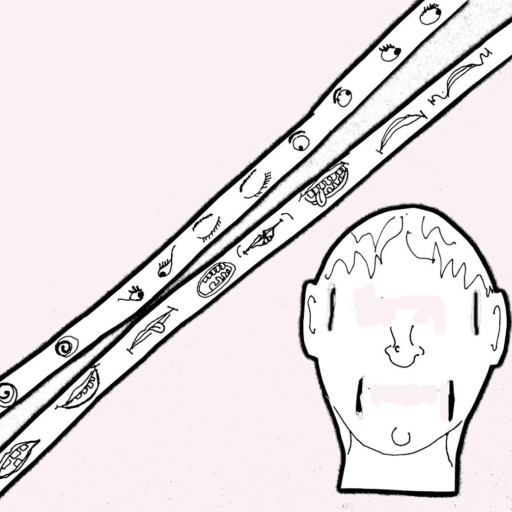

The Helpful Art Teacher Cartooning And Animation


In [331]:
toPIL = T.ToPILImage()
a11 = toPIL(a[0][9])
a11.show()
print(a[1][9])

In [334]:
a[1]

['<PERSON>',
 "The originator of the ``Panel Paint Job'' Custom Paint Jobs, Custom Cars, Classic Trucks, Classic Cars, <PERSON>, 1954 Chevy Bel Air, Hot Rod Trucks, Kustom Kulture, Sweet Cars",
 'Prickly pear fruits on cactus. Opuntia, commonly called prickly pear, with rosy fruits. Prickly pears produces a fruit, commonly eaten in Mexico and in the stock photography',
 "Architectural Digest has just published a tour of <PERSON>'s English country house and <PERSON> everywhere will delight in the magical interiors. The supermodel shares the Tudor mansion with her husband English film director <PERSON> and <PERSON>, The Tudors, Antique Bench, Estilo Tropical, Sweet Home, Living Spaces, Living Room, Tudor House, Vogue Living",
 'Rugrats In Paris: The Movie Nintendo 64 Gray Variant Cartridge Rugrats, Nintendo 64, Paris, <PERSON>, Movies, <PERSON>, Films, Grey, Film',
 'Alternate view of Pattern - Cactuses in the pots Framed Art Print',
 'Happy and proud of first aid kit wearing a black Gra

In [230]:
w = (14 - 2) * torch.rand((bsz,)) + 2
print(w)

tensor([ 8.4952, 10.5124,  4.6375,  8.8981,  7.0893,  4.6318,  7.9396,  5.3337,
         5.0518,  5.7027,  9.9192, 12.7940,  3.7188, 12.8106,  8.6100,  8.5384,
        10.5508,  9.6891,  9.6643,  8.0309,  7.4343,  4.5367,  8.0744,  7.4331,
         2.8961,  8.0449,  4.3172,  7.5066,  8.9374,  2.2489,  9.7555,  4.2370])


#### Guidance Scale Emb

In [76]:
# From LatentConsistencyModel.get_guidance_scale_embedding
def guidance_scale_embedding(w, embedding_dim=256, dtype=torch.float32):
    assert len(w.shape) == 1
    w = w * 1000.0

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
    emb = w.to(dtype)[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1))
    assert emb.shape == (w.shape[0], embedding_dim)
    return emb

In [49]:
w=torch.tensor([4])
embedding_dim=256
dtype=torch.float32

w = w * 1000.0
half_dim = embedding_dim // 2
emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
emb = w.to(dtype)[:, None] * emb[None, :]

In [40]:
print(w.to(dtype)[:, None])

tensor([[4000.]])


#### Timestep Emb

In [55]:
class TimestepEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int,
        time_embed_dim: int,
        act_fn: str = "silu",
        out_dim: int = None,
        post_act_fn: Optional[str] = None,
        cond_proj_dim=None, #256 for LCMS
        sample_proj_bias=True,
    ):
        super().__init__()

        self.linear_1 = nn.Linear(in_channels, time_embed_dim, sample_proj_bias)

        if cond_proj_dim is not None:
            self.cond_proj = nn.Linear(cond_proj_dim, in_channels, bias=False)
        else:
            self.cond_proj = None

        self.act = get_activation(act_fn)

        if out_dim is not None:
            time_embed_dim_out = out_dim
        else:
            time_embed_dim_out = time_embed_dim
        self.linear_2 = nn.Linear(time_embed_dim, time_embed_dim_out, sample_proj_bias)

        if post_act_fn is None:
            self.post_act = None
        else:
            self.post_act = get_activation(post_act_fn)

    def forward(self, sample, condition=None):
        if condition is not None:
            sample = sample + self.cond_proj(condition)
        sample = self.linear_1(sample)

        if self.act is not None:
            sample = self.act(sample)

        sample = self.linear_2(sample)

        if self.post_act is not None:
            sample = self.post_act(sample)
        return sample

In [68]:
class Timesteps(nn.Module):
    def __init__(self, num_channels: int, flip_sin_to_cos: bool, downscale_freq_shift: float, scale: int = 1):
        super().__init__()
        self.num_channels = num_channels
        self.flip_sin_to_cos = flip_sin_to_cos
        self.downscale_freq_shift = downscale_freq_shift
        self.scale = scale

    def forward(self, timesteps):
        t_emb = get_timestep_embedding(
            timesteps,
            self.num_channels,
            flip_sin_to_cos=self.flip_sin_to_cos,
            downscale_freq_shift=self.downscale_freq_shift,
            scale=self.scale,
        )
        return t_emb
    
def get_timestep_embedding(
    timesteps: torch.Tensor,
    embedding_dim: int,
    flip_sin_to_cos: bool = False,
    downscale_freq_shift: float = 1,
    scale: float = 1,
    max_period: int = 10000,
):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models: Create sinusoidal timestep embeddings.

    Args
        timesteps (torch.Tensor):
            a 1-D Tensor of N indices, one per batch element. These may be fractional.
        embedding_dim (int):
            the dimension of the output.
        flip_sin_to_cos (bool):
            Whether the embedding order should be `cos, sin` (if True) or `sin, cos` (if False)
        downscale_freq_shift (float):
            Controls the delta between frequencies between dimensions
        scale (float):
            Scaling factor applied to the embeddings.
        max_period (int):
            Controls the maximum frequency of the embeddings
    Returns
        torch.Tensor: an [N x dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1d-array"

    half_dim = embedding_dim // 2
    exponent = -math.log(max_period) * torch.arange(start=0, end=half_dim, dtype=torch.float32, device=timesteps.device)
    exponent = exponent / (half_dim - downscale_freq_shift)
    emb = torch.exp(exponent)
    emb = timesteps[:, None].float() * emb[None, :]
    # scale embeddings
    emb = scale * emb
    # concat sine and cosine embeddings
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    # flip sine and cosine embeddings
    if flip_sin_to_cos:
        emb = torch.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)
    # zero pad
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [70]:
def _set_time_proj(
        time_embedding_type: str,
        block_out_channels: int,
        flip_sin_to_cos: bool,
        freq_shift: float,
        time_embedding_dim: int
    ,
    ) -> Tuple[int, int]:

        if time_embedding_type == "positional":
            time_embed_dim = time_embedding_dim or block_out_channels[0] * 4

            time_proj = Timesteps(block_out_channels[0], flip_sin_to_cos, freq_shift)
            timestep_input_dim = block_out_channels[0]
        else:
            raise ValueError(
                f"{time_embedding_type} does not exist. Please make sure to use one of `fourier` or `positional`."
            )

        return time_embed_dim, timestep_input_dim

In [73]:
time_embed_dim, timestep_input_dim = _set_time_proj(
            time_embedding_type="positional",
            block_out_channels=(320, 640, 1280, 1280),
            flip_sin_to_cos=True,
            freq_shift=0,
            time_embedding_dim=None,
        )
print("time_embed_dim=", time_embed_dim)
print("timestep_input_dim=", timestep_input_dim)

time_embed_dim= 1280
timestep_input_dim= 320


In [62]:
teacher_unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

### Test

In [15]:
class NoiseScheduler():
    def __init__(self, 
                 beta: Tuple[float, float] = (0.0001, 0.02), 
                 T:int = 1000, 
                 beta_schedule: str = "linear",
                 trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
                 prediction_type: str = "epsilon",
                 rescale_betas_zero_snr: bool = False
                ):
        
        self.beta_start = beta[0]
        self.beta_end = beta[1]
        self.num_train_timesteps = T
        
        #self.config = EasyDict({'foo':3, 'bar':{'x':1, 'y':2}})
        
        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(self.beta_start, self.beta_end, self.num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = torch.linspace(self.beta_start**0.5, self.beta_end**0.5, self.num_train_timesteps, dtype=torch.float32) ** 2
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(self.num_train_timesteps)
        elif beta_schedule == "sigmoid":
            # GeoDiff sigmoid schedule
            betas = torch.linspace(-6, 6, num_train_timesteps)
            self.betas = torch.sigmoid(betas) * (self.beta_end - self.beta_start) + self.beta_start
        else:
            raise NotImplementedError(f"{beta_schedule} is not implemented for {self.__class__}")

        
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0, dtype=torch.float32)
        self.alpha_schedule = torch.sqrt(self.alphas_cumprod)
        self.sigma_schedule = torch.sqrt(1 - self.alphas_cumprod)
        self.one = torch.tensor(1.0)

In [16]:
scheduler2 = NoiseScheduler()

In [24]:
print(scheduler2.alphas_cumprod.shape)
print(noise_scheduler.alphas_cumprod.shape)

torch.Size([1000])
torch.Size([1000])


In [37]:
import matplotlib.pyplot as plt

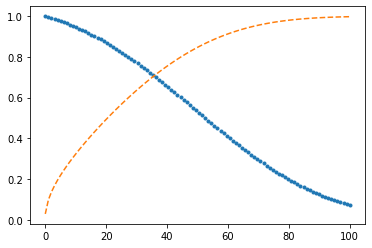

In [41]:
alpha_schedule = torch.sqrt(noise_scheduler.alphas_cumprod)
sigma_schedule = torch.sqrt(1 - noise_scheduler.alphas_cumprod)
plt.plot(np.linspace(0,100,100) ,(np.sqrt(noise_scheduler.alphas_cumprod[::10])), '.', np.linspace(0,100,100) ,np.sqrt(1-noise_scheduler.alphas_cumprod[::10]),'--')

In [98]:
solver = DDIMSolver(
    noise_scheduler.alphas_cumprod.numpy(),
    timesteps=noise_scheduler.config.num_train_timesteps,
    ddim_timesteps=num_ddim_timesteps,
)

In [97]:
topk = 1000 // 50
index = torch.randint(0, num_ddim_timesteps, (bsz,)).long()
print(index)

tensor([31, 19, 13,  9, 43, 29, 24, 27, 37, 13, 27, 45])


In [99]:
start_timesteps = solver.ddim_timesteps[index]
print(start_timesteps)

tensor([639, 399, 279, 199, 879, 599, 499, 559, 759, 279, 559, 919])


In [100]:
timesteps = start_timesteps - topk
timesteps = torch.where(timesteps < 0, torch.zeros_like(timesteps), timesteps)
print(timesteps)


tensor([619, 379, 259, 179, 859, 579, 479, 539, 739, 259, 539, 899])


In [52]:
alpha_cumprods = noise_scheduler.alphas_cumprod.numpy()
ddim_alpha_cumprods = alpha_cumprods[solver.ddim_timesteps]
print(ddim_alpha_cumprods)

[0.98224396 0.9628949  0.9419623  0.919471   0.89546245 0.8699941
 0.8431398  0.8149898  0.78564924 0.75523806 0.72389    0.69175035
 0.65897524 0.62572914 0.5921829  0.5585115  0.524892   0.49150017
 0.45850915 0.42608616 0.39439055 0.36357138 0.33376545 0.3050957
 0.27766946 0.25157756 0.2268934  0.20367236 0.18195204 0.16175242
 0.14307629 0.12591045 0.11022681 0.09598386 0.08312827 0.07159668
 0.06131752 0.05221289 0.04420042 0.03719497 0.03111038 0.02586088
 0.02136249 0.01753415 0.01429867 0.01158345 0.00932107 0.00744959
 0.00591277 0.0046601 ]


In [297]:
ddim_alpha_cumprods_prev = np.asarray(
    [alpha_cumprods[0]] + alpha_cumprods[solver.ddim_timesteps[:-1]].tolist()
)
print(ddim_alpha_cumprods_prev)

[0.99914998 0.98224396 0.96289492 0.9419623  0.91947103 0.89546245
 0.8699941  0.84313983 0.81498981 0.78564924 0.75523806 0.72389001
 0.69175035 0.65897524 0.62572914 0.59218287 0.5585115  0.52489197
 0.49150017 0.45850915 0.42608616 0.39439055 0.36357138 0.33376545
 0.3050957  0.27766946 0.25157756 0.2268934  0.20367236 0.18195204
 0.16175242 0.14307629 0.12591045 0.11022681 0.09598386 0.08312827
 0.07159668 0.06131752 0.05221289 0.04420042 0.03719497 0.03111038
 0.02586088 0.02136249 0.01753415 0.01429867 0.01158345 0.00932107
 0.00744959 0.00591277]


In [303]:
t = start_timesteps
a = torch.sqrt(noise_scheduler.alphas_cumprod)
b, *_ = t.shape
print(b)
print(a.shape)

32
torch.Size([1000])


In [305]:
print(t)

tensor([199, 539, 899, 159, 519, 199, 859, 679, 399, 519, 399, 279, 839, 319,
        939, 179, 299, 679, 199, 619, 379, 299, 859,  79, 599, 919,  99, 459,
        939, 999, 139, 619])


In [318]:
out = a.gather(-1, t)
print(out)
print(out.shape)

tensor([0.8690, 0.4763, 0.1196, 0.9028, 0.5016, 0.8690, 0.1462, 0.3098, 0.6528,
        0.5016, 0.6528, 0.7910, 0.1608, 0.7473, 0.0965, 0.8864, 0.7695, 0.3098,
        0.8690, 0.3783, 0.6771, 0.7695, 0.1462, 0.9589, 0.4022, 0.1076, 0.9463,
        0.5777, 0.0965, 0.0683, 0.9182, 0.3783])
torch.Size([32])


## Main

In [30]:
pretrained_teacher_model = "runwayml/stable-diffusion-v1-5"
num_ddim_timesteps = 50
unet_time_cond_proj_dim = 256
learning_rate=1e-6
loss_type="huber"
ema_decay=0.95
adam_weight_decay=0.0
adam_beta1=0.9
adam_beta2=0.999
adam_epsilon=1e-08
GRADIENT_ACCUM_STEPS=1
MIXED_PRECISION="fp16"
REPORT_TO = "wandb"
max_train_steps=1000
num_train_epochs = 100
lr_scheduler="constant"
lr_warmup_steps=500
#bsz = 32
train_batch_size = 12

In [60]:
os.getcwd()

'/root/notebooks/LCMtest'

In [61]:
output_dir = "./LCMtest/output"
logging_dir = "logs"
logging_dir = Path(output_dir, logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=logging_dir)

In [64]:
accelerator = Accelerator(
    gradient_accumulation_steps=GRADIENT_ACCUM_STEPS,
    mixed_precision=MIXED_PRECISION,
    split_batches=True,  # It's important to set this to True when using webdataset to get the right number of steps for lr scheduling. If set to False, the number of steps will be devide by the number of processes assuming batches are multiplied by the number of processes
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [80]:
noise_scheduler_diffuser = DDPMScheduler.from_pretrained(
     pretrained_teacher_model, subfolder="scheduler", revision=None)

In [81]:
help(noise_scheduler_diffuser.add_noise)

Help on method add_noise in module diffusers.schedulers.scheduling_ddpm:

add_noise(original_samples: torch.Tensor, noise: torch.Tensor, timesteps: torch.IntTensor) -> torch.Tensor method of diffusers.schedulers.scheduling_ddpm.DDPMScheduler instance



In [19]:
class NoiseScheduler():
    def __init__(self, 
                 beta: Tuple[float, float] = (0.0001, 0.02), 
                 T:int = 1000, 
                 beta_schedule: str = "linear",
                 trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
                 prediction_type: str = "epsilon",
                 rescale_betas_zero_snr: bool = False
                ):
        
        self.beta_start = beta[0]
        self.beta_end = beta[1]
        self.num_train_timesteps = T
        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(self.beta_start, self.beta_end, self.num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = torch.linspace(self.beta_start**0.5, self.beta_end**0.5, self.num_train_timesteps, dtype=torch.float32) ** 2
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(self.num_train_timesteps)
        elif beta_schedule == "sigmoid":
            # GeoDiff sigmoid schedule
            betas = torch.linspace(-6, 6, num_train_timesteps)
            self.betas = torch.sigmoid(betas) * (self.beta_end - self.beta_start) + self.beta_start
        else:
            raise NotImplementedError(f"{beta_schedule} is not implemented for {self.__class__}")

        
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0, dtype=torch.float32)
        self.alpha_schedule = torch.sqrt(self.alphas_cumprod)
        self.sigma_schedule = torch.sqrt(1 - self.alphas_cumprod)
        self.one = torch.tensor(1.0)

In [22]:
# 1. Create the noise scheduler and the desired noise schedule.
# noise_scheduler = DDPMScheduler.from_pretrained(
#     pretrained_teacher_model, subfolder="scheduler", revision=None
# )
noise_scheduler = NoiseScheduler()
# DDPMScheduler calculates the alpha and sigma noise schedules (based on the alpha bars) for us
# alpha_schedule = torch.sqrt(noise_scheduler.alphas_cumprod)
# sigma_schedule = torch.sqrt(1 - noise_scheduler.alphas_cumprod)
alpha_schedule = noise_scheduler.alpha_schedule
sigma_schedule = noise_scheduler.sigma_schedule

# Initialize the DDIM ODE solver for distillation.
solver = DDIMSolver(
    noise_scheduler.alphas_cumprod.numpy(),
    timesteps=noise_scheduler.num_train_timesteps,
    ddim_timesteps=num_ddim_timesteps, #num_ddim_timesteps=50 or 100?
)

In [54]:
pretrained_teacher_model = "SimianLuo/LCM_Dreamshaper_v7"
# 2. Load tokenizers from SD 1.X/2.X checkpoint.
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_teacher_model, subfolder="tokenizer", use_fast=False)

# 3. Load text encoders from SD 1.X/2.X checkpoint.
# import correct text encoder classes
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_teacher_model, subfolder="text_encoder")

# 4. Load VAE from SD 1.X/2.X checkpoint
vae = AutoencoderKL.from_pretrained(
    pretrained_teacher_model, subfolder="vae")

In [59]:
teacher_unet = UNet2DConditionModel.from_pretrained(pretrained_teacher_model, subfolder="unet")
teacher_unet.requires_grad_(False)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features

In [ ]:
class Args(argparse.Namespace):
    arch = "unet"
    train_batch_size=32
    img_size=64
    num_timestep = 1000
    beta = (0.0001, 0.02)
    num_condition = [4, 2]
    emb_size = 128
    channel_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    use_spatial_transformer = True
    num_heads = 4
    num_sample_missing = 1
    num_sample = 10
    w = 1.8
    projection_dim=512
    only_table = False
    concat = False
    only_encoder = False
    num_head_channels = -1
    encoder_path = None
    dataset = "CelebA"
    exp = "GFemaleAdd"
    compose=False
    num_ddim_timesteps = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

In [32]:
# 5. Load teacher U-Net from SD 1.X/2.X checkpoint
# teacher_unet = UNet2DConditionModel.from_pretrained(
#     pretrained_teacher_model, subfolder="unet")
teacher_unet = get_model(args)

# 6. Freeze teacher vae, text_encoder, and teacher_unet
# vae.requires_grad_(False)
# text_encoder.requires_grad_(False)
# teacher_unet.requires_grad_(False)

NameError: name 'get_model' is not defined

In [67]:
# 7. Create online student U-Net. This will be updated by the optimizer (e.g. via backpropagation.)
# Add `time_cond_proj_dim` to the student U-Net if `teacher_unet.config.time_cond_proj_dim` is None
# time_cond_proj_dim = (
#     teacher_unet.config.time_cond_proj_dim
#     if teacher_unet.config.time_cond_proj_dim is not None
#     else unet_time_cond_proj_dim
# )
time_cond_proj_dim = unet_time_cond_proj_dim

unet = UNet2DConditionModel.from_config(teacher_unet.config, time_cond_proj_dim=time_cond_proj_dim)
# load teacher_unet weights into unet
unet.load_state_dict(teacher_unet.state_dict(), strict=False)
unet.train()
# 8. Create target student U-Net. This will be updated via EMA updates (polyak averaging).
# Initialize from (online) unet
target_unet = UNet2DConditionModel.from_config(unet.config)
target_unet.load_state_dict(unet.state_dict())
target_unet.train()
target_unet.requires_grad_(False)
print("done")

done


In [78]:
# Check that all trainable models are in full precision
low_precision_error_string = (
    " Please make sure to always have all model weights in full float32 precision when starting training - even if"
    " doing mixed precision training, copy of the weights should still be float32."
)

if accelerator.unwrap_model(unet).dtype != torch.float32:
    raise ValueError(
        f"Controlnet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
    )

# 9. Handle mixed precision and device placement
# For mixed precision training we cast all non-trainable weigths to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

In [109]:
type(accelerator.device)

torch.device

In [31]:
# Move unet, vae and text_encoder to device and cast to weight_dtype
# The VAE is in float32 to avoid NaN losses.
vae.to(accelerator.device)
# if args.pretrained_vae_model_name_or_path is not None:
#     vae.to(dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

# Move teacher_unet to device, optionally cast to weight_dtype
target_unet.to(accelerator.device)
teacher_unet.to(accelerator.device)
# if args.cast_teacher_unet:
#     teacher_unet.to(dtype=weight_dtype)

# Also move the alpha and sigma noise schedules to accelerator.device.
alpha_schedule = alpha_schedule.to(accelerator.device)
sigma_schedule = sigma_schedule.to(accelerator.device)
solver = solver.to(accelerator.device)


NameError: name 'vae' is not defined

device(type='cpu')

In [84]:
# 10. Handle saving and loading of checkpoints
# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            target_unet.save_pretrained(os.path.join(output_dir, "unet_target"))

            for i, model in enumerate(models):
                model.save_pretrained(os.path.join(output_dir, "unet"))

                # make sure to pop weight so that corresponding model is not saved again
                weights.pop()

    def load_model_hook(models, input_dir):
        load_model = UNet2DConditionModel.from_pretrained(os.path.join(input_dir, "unet_target"))
        target_unet.load_state_dict(load_model.state_dict())
        target_unet.to(accelerator.device)
        del load_model

        for i in range(len(models)):
            # pop models so that they are not loaded again
            model = models.pop()

            # load diffusers style into model
            load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

In [89]:
# 11. Enable optimizations
enable_xformers_memory_efficient_attention = False

if enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warning(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
        teacher_unet.enable_xformers_memory_efficient_attention()
        target_unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
allow_tf32 = False
if allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
    
gradient_checkpointing = True
if gradient_checkpointing:
    unet.enable_gradient_checkpointing()

use_8bit_adam = False    
if use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

In [86]:
import xformers

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.3.1+cu121 with CUDA 1201 (you have 1.10.0+cu113)
    Python  3.8.19 (you have 3.8.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


ImportError: cannot import name '_len_torch_dispatch_stack' from 'torch._C' (/usr/local/lib/python3.8/dist-packages/torch/_C.cpython-38-x86_64-linux-gnu.so)

In [90]:
# 12. Optimizer creation
optimizer = optimizer_class(
    unet.parameters(),
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

In [34]:
# 13. Dataset creation and data processing
# Here, we compute not just the text embeddings but also the additional embeddings
# needed for the SD XL UNet to operate.
def compute_embeddings(prompt_batch, proportion_empty_prompts, text_encoder, tokenizer, is_train=True):
    prompt_embeds = encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train)
    return {"prompt_embeds": prompt_embeds}

dataset = SDText2ImageDataset(
    train_shards_path_or_url="pipe:curl -L -s https://huggingface.co/datasets/laion/conceptual-captions-12m-webdataset/resolve/main/data/{00000..01099}.tar?download=true",
    num_train_examples=40000,
    per_gpu_batch_size=12,
    global_batch_size=12 * 2,
    num_workers=8,
    resolution=512,
    interpolation_type="bilinear",
    shuffle_buffer_size=1000,
    pin_memory=True,
    persistent_workers=True,
)

train_dataloader = dataset.train_dataloader

# compute_embeddings_fn = functools.partial(
#     compute_embeddings,
#     proportion_empty_prompts=0,
#     text_encoder=text_encoder,
#     tokenizer=tokenizer,
# )

In [92]:
# 14. LR Scheduler creation
# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(train_dataloader.num_batches / gradient_accumulation_steps)
if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
)

In [93]:
# 15. Prepare for training
# Prepare everything with our `accelerator`.

unet, optimizer, lr_scheduler = accelerator.prepare(unet, optimizer, lr_scheduler)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(train_dataloader.num_batches / gradient_accumulation_steps)
if overrode_max_train_steps:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
# if accelerator.is_main_process:
#     tracker_config = dict(vars(args))
#     accelerator.init_trackers(args.tracker_project_name, config=tracker_config)

In [77]:
accelerator.device

device(type='cuda')

In [94]:
uncond_input_ids = tokenizer(
        [""] * train_batch_size, return_tensors="pt", padding="max_length", max_length=77
    ).input_ids.to(accelerator.device)
uncond_prompt_embeds = text_encoder(uncond_input_ids)[0]

In [100]:
tokenizer([""] * train_batch_size, return_tensors="pt", padding="max_length", max_length=77).input_ids.shape

torch.Size([12, 77])

In [27]:
def main(args):
    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `huggingface-cli login` to authenticate with the Hub."
        )

    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
        split_batches=True,  # It's important to set this to True when using webdataset to get the right number of steps for lr scheduling. If set to False, the number of steps will be devide by the number of processes assuming batches are multiplied by the number of processes
    )

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name,
                exist_ok=True,
                token=args.hub_token,
                private=True,
            ).repo_id

    # 1. Create the noise scheduler and the desired noise schedule.
    noise_scheduler = DDPMScheduler.from_pretrained(
        args.pretrained_teacher_model, subfolder="scheduler", revision=args.teacher_revision
    )

    # DDPMScheduler calculates the alpha and sigma noise schedules (based on the alpha bars) for us
    alpha_schedule = torch.sqrt(noise_scheduler.alphas_cumprod)
    sigma_schedule = torch.sqrt(1 - noise_scheduler.alphas_cumprod)
    # Initialize the DDIM ODE solver for distillation.
    solver = DDIMSolver(
        noise_scheduler.alphas_cumprod.numpy(),
        timesteps=noise_scheduler.config.num_train_timesteps,
        ddim_timesteps=args.num_ddim_timesteps,
    )

    # 2. Load tokenizers from SD 1.X/2.X checkpoint.
    tokenizer = AutoTokenizer.from_pretrained(
        args.pretrained_teacher_model, subfolder="tokenizer", revision=args.teacher_revision, use_fast=False
    )

    # 3. Load text encoders from SD 1.X/2.X checkpoint.
    # import correct text encoder classes
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_teacher_model, subfolder="text_encoder", revision=args.teacher_revision
    )

    # 4. Load VAE from SD 1.X/2.X checkpoint
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_teacher_model,
        subfolder="vae",
        revision=args.teacher_revision,
    )

    # 5. Load teacher U-Net from SD 1.X/2.X checkpoint
    teacher_unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_teacher_model, subfolder="unet", revision=args.teacher_revision
    )

    # 6. Freeze teacher vae, text_encoder, and teacher_unet
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    teacher_unet.requires_grad_(False)

    # 7. Create online student U-Net. This will be updated by the optimizer (e.g. via backpropagation.)
    # Add `time_cond_proj_dim` to the student U-Net if `teacher_unet.config.time_cond_proj_dim` is None
    time_cond_proj_dim = (
        teacher_unet.config.time_cond_proj_dim
        if teacher_unet.config.time_cond_proj_dim is not None
        else args.unet_time_cond_proj_dim
    )
    unet = UNet2DConditionModel.from_config(teacher_unet.config, time_cond_proj_dim=time_cond_proj_dim)
    # load teacher_unet weights into unet
    unet.load_state_dict(teacher_unet.state_dict(), strict=False)
    unet.train()

    # 8. Create target student U-Net. This will be updated via EMA updates (polyak averaging).
    # Initialize from (online) unet
    target_unet = UNet2DConditionModel.from_config(unet.config)
    target_unet.load_state_dict(unet.state_dict())
    target_unet.train()
    target_unet.requires_grad_(False)

    # Check that all trainable models are in full precision
    low_precision_error_string = (
        " Please make sure to always have all model weights in full float32 precision when starting training - even if"
        " doing mixed precision training, copy of the weights should still be float32."
    )

    if accelerator.unwrap_model(unet).dtype != torch.float32:
        raise ValueError(
            f"Controlnet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
        )

    # 9. Handle mixed precision and device placement
    # For mixed precision training we cast all non-trainable weigths to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    # The VAE is in float32 to avoid NaN losses.
    vae.to(accelerator.device)
    if args.pretrained_vae_model_name_or_path is not None:
        vae.to(dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # Move teacher_unet to device, optionally cast to weight_dtype
    target_unet.to(accelerator.device)
    teacher_unet.to(accelerator.device)
    if args.cast_teacher_unet:
        teacher_unet.to(dtype=weight_dtype)

    # Also move the alpha and sigma noise schedules to accelerator.device.
    alpha_schedule = alpha_schedule.to(accelerator.device)
    sigma_schedule = sigma_schedule.to(accelerator.device)
    solver = solver.to(accelerator.device)

    # 10. Handle saving and loading of checkpoints
    # `accelerate` 0.16.0 will have better support for customized saving
    if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
        # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
        def save_model_hook(models, weights, output_dir):
            if accelerator.is_main_process:
                target_unet.save_pretrained(os.path.join(output_dir, "unet_target"))

                for i, model in enumerate(models):
                    model.save_pretrained(os.path.join(output_dir, "unet"))

                    # make sure to pop weight so that corresponding model is not saved again
                    weights.pop()

        def load_model_hook(models, input_dir):
            load_model = UNet2DConditionModel.from_pretrained(os.path.join(input_dir, "unet_target"))
            target_unet.load_state_dict(load_model.state_dict())
            target_unet.to(accelerator.device)
            del load_model

            for i in range(len(models)):
                # pop models so that they are not loaded again
                model = models.pop()

                # load diffusers style into model
                load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
                model.register_to_config(**load_model.config)

                model.load_state_dict(load_model.state_dict())
                del load_model

        accelerator.register_save_state_pre_hook(save_model_hook)
        accelerator.register_load_state_pre_hook(load_model_hook)

    # 11. Enable optimizations
    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
            teacher_unet.enable_xformers_memory_efficient_attention()
            target_unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
            )

        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    # 12. Optimizer creation
    optimizer = optimizer_class(
        unet.parameters(),
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # 13. Dataset creation and data processing
    # Here, we compute not just the text embeddings but also the additional embeddings
    # needed for the SD XL UNet to operate.
    def compute_embeddings(prompt_batch, proportion_empty_prompts, text_encoder, tokenizer, is_train=True):
        prompt_embeds = encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train)
        return {"prompt_embeds": prompt_embeds}

    dataset = SDText2ImageDataset(
        train_shards_path_or_url=args.train_shards_path_or_url,
        num_train_examples=args.max_train_samples,
        per_gpu_batch_size=args.train_batch_size,
        global_batch_size=args.train_batch_size * accelerator.num_processes,
        num_workers=args.dataloader_num_workers,
        resolution=args.resolution,
        interpolation_type=args.interpolation_type,
        shuffle_buffer_size=1000,
        pin_memory=True,
        persistent_workers=True,
    )
    train_dataloader = dataset.train_dataloader

    compute_embeddings_fn = functools.partial(
        compute_embeddings,
        proportion_empty_prompts=0,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
    )

    # 14. LR Scheduler creation
    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(train_dataloader.num_batches / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps,
        num_training_steps=args.max_train_steps,
    )

    # 15. Prepare for training
    # Prepare everything with our `accelerator`.
    unet, optimizer, lr_scheduler = accelerator.prepare(unet, optimizer, lr_scheduler)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(train_dataloader.num_batches / args.gradient_accumulation_steps)
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        tracker_config = dict(vars(args))
        accelerator.init_trackers(args.tracker_project_name, config=tracker_config)

    uncond_input_ids = tokenizer(
        [""] * args.train_batch_size, return_tensors="pt", padding="max_length", max_length=77
    ).input_ids.to(accelerator.device)
    uncond_prompt_embeds = text_encoder(uncond_input_ids)[0]

    # 16. Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num batches each epoch = {train_dataloader.num_batches}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, args.num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # 1. Load and process the image and text conditioning
                image, text = batch

                image = image.to(accelerator.device, non_blocking=True)
                encoded_text = compute_embeddings_fn(text)

                pixel_values = image.to(dtype=weight_dtype)
                if vae.dtype != weight_dtype:
                    vae.to(dtype=weight_dtype)

                # encode pixel values with batch size of at most args.vae_encode_batch_size
                latents = []
                for i in range(0, pixel_values.shape[0], args.vae_encode_batch_size):
                    latents.append(vae.encode(pixel_values[i : i + args.vae_encode_batch_size]).latent_dist.sample())
                latents = torch.cat(latents, dim=0)

                latents = latents * vae.config.scaling_factor
                latents = latents.to(weight_dtype)
                bsz = latents.shape[0]

                # 2. Sample a random timestep for each image t_n from the ODE solver timesteps without bias.
                # For the DDIM solver, the timestep schedule is [T - 1, T - k - 1, T - 2 * k - 1, ...]
                topk = noise_scheduler.config.num_train_timesteps // args.num_ddim_timesteps
                index = torch.randint(0, args.num_ddim_timesteps, (bsz,), device=latents.device).long()
                start_timesteps = solver.ddim_timesteps[index]
                timesteps = start_timesteps - topk
                timesteps = torch.where(timesteps < 0, torch.zeros_like(timesteps), timesteps)

                # 3. Get boundary scalings for start_timesteps and (end) timesteps.
                c_skip_start, c_out_start = scalings_for_boundary_conditions(
                    start_timesteps, timestep_scaling=args.timestep_scaling_factor
                )
                c_skip_start, c_out_start = [append_dims(x, latents.ndim) for x in [c_skip_start, c_out_start]]
                c_skip, c_out = scalings_for_boundary_conditions(
                    timesteps, timestep_scaling=args.timestep_scaling_factor
                )
                c_skip, c_out = [append_dims(x, latents.ndim) for x in [c_skip, c_out]]

                # 4. Sample noise from the prior and add it to the latents according to the noise magnitude at each
                # timestep (this is the forward diffusion process) [z_{t_{n + k}} in Algorithm 1]
                noise = torch.randn_like(latents)
                noisy_model_input = noise_scheduler.add_noise(latents, noise, start_timesteps)

                # 5. Sample a random guidance scale w from U[w_min, w_max] and embed it
                w = (args.w_max - args.w_min) * torch.rand((bsz,)) + args.w_min
                w_embedding = guidance_scale_embedding(w, embedding_dim=time_cond_proj_dim)
                w = w.reshape(bsz, 1, 1, 1)
                # Move to U-Net device and dtype
                w = w.to(device=latents.device, dtype=latents.dtype)
                w_embedding = w_embedding.to(device=latents.device, dtype=latents.dtype)

                # 6. Prepare prompt embeds and unet_added_conditions
                prompt_embeds = encoded_text.pop("prompt_embeds")

                # 7. Get online LCM prediction on z_{t_{n + k}} (noisy_model_input), w, c, t_{n + k} (start_timesteps)
                noise_pred = unet(
                    noisy_model_input,
                    start_timesteps,
                    timestep_cond=w_embedding,
                    encoder_hidden_states=prompt_embeds.float(),
                    added_cond_kwargs=encoded_text,
                ).sample

                pred_x_0 = get_predicted_original_sample(
                    noise_pred,
                    start_timesteps,
                    noisy_model_input,
                    noise_scheduler.config.prediction_type,
                    alpha_schedule,
                    sigma_schedule,
                )

                model_pred = c_skip_start * noisy_model_input + c_out_start * pred_x_0

                # 8. Compute the conditional and unconditional teacher model predictions to get CFG estimates of the
                # predicted noise eps_0 and predicted original sample x_0, then run the ODE solver using these
                # estimates to predict the data point in the augmented PF-ODE trajectory corresponding to the next ODE
                # solver timestep.
                with torch.no_grad():
                    if torch.backends.mps.is_available():
                        autocast_ctx = nullcontext()
                    else:
                        autocast_ctx = torch.autocast(accelerator.device.type)

                    with autocast_ctx:
                        # 1. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and conditional embedding c
                        cond_teacher_output = teacher_unet(
                            noisy_model_input.to(weight_dtype),
                            start_timesteps,
                            encoder_hidden_states=prompt_embeds.to(weight_dtype),
                        ).sample
                        cond_pred_x0 = get_predicted_original_sample(
                            cond_teacher_output,
                            start_timesteps,
                            noisy_model_input,
                            noise_scheduler.config.prediction_type,
                            alpha_schedule,
                            sigma_schedule,
                        )
                        cond_pred_noise = get_predicted_noise(
                            cond_teacher_output,
                            start_timesteps,
                            noisy_model_input,
                            noise_scheduler.config.prediction_type,
                            alpha_schedule,
                            sigma_schedule,
                        )

                        # 2. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and unconditional embedding 0
                        uncond_teacher_output = teacher_unet(
                            noisy_model_input.to(weight_dtype),
                            start_timesteps,
                            encoder_hidden_states=uncond_prompt_embeds.to(weight_dtype),
                        ).sample
                        uncond_pred_x0 = get_predicted_original_sample(
                            uncond_teacher_output,
                            start_timesteps,
                            noisy_model_input,
                            noise_scheduler.config.prediction_type,
                            alpha_schedule,
                            sigma_schedule,
                        )
                        uncond_pred_noise = get_predicted_noise(
                            uncond_teacher_output,
                            start_timesteps,
                            noisy_model_input,
                            noise_scheduler.config.prediction_type,
                            alpha_schedule,
                            sigma_schedule,
                        )

                        # 3. Calculate the CFG estimate of x_0 (pred_x0) and eps_0 (pred_noise)
                        # Note that this uses the LCM paper's CFG formulation rather than the Imagen CFG formulation
                        pred_x0 = cond_pred_x0 + w * (cond_pred_x0 - uncond_pred_x0)
                        pred_noise = cond_pred_noise + w * (cond_pred_noise - uncond_pred_noise)
                        # 4. Run one step of the ODE solver to estimate the next point x_prev on the
                        # augmented PF-ODE trajectory (solving backward in time)
                        # Note that the DDIM step depends on both the predicted x_0 and source noise eps_0.
                        x_prev = solver.ddim_step(pred_x0, pred_noise, index)

                # 9. Get target LCM prediction on x_prev, w, c, t_n (timesteps)
                with torch.no_grad():
                    if torch.backends.mps.is_available():
                        autocast_ctx = nullcontext()
                    else:
                        autocast_ctx = torch.autocast(accelerator.device.type, dtype=weight_dtype)

                    with autocast_ctx:
                        target_noise_pred = target_unet(
                            x_prev.float(),
                            timesteps,
                            timestep_cond=w_embedding,
                            encoder_hidden_states=prompt_embeds.float(),
                        ).sample
                    pred_x_0 = get_predicted_original_sample(
                        target_noise_pred,
                        timesteps,
                        x_prev,
                        noise_scheduler.config.prediction_type,
                        alpha_schedule,
                        sigma_schedule,
                    )
                    target = c_skip * x_prev + c_out * pred_x_0

                # 10. Calculate loss
                if args.loss_type == "l2":
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
                elif args.loss_type == "huber":
                    loss = torch.mean(
                        torch.sqrt((model_pred.float() - target.float()) ** 2 + args.huber_c**2) - args.huber_c
                    )

                # 11. Backpropagate on the online student model (`unet`)
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=True)

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                # 12. Make EMA update to target student model parameters (`target_unet`)
                update_ema(target_unet.parameters(), unet.parameters(), args.ema_decay)
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process:
                    if global_step % args.checkpointing_steps == 0:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

                    if global_step % args.validation_steps == 0:
                        log_validation(vae, target_unet, args, accelerator, weight_dtype, global_step, "target")
                        log_validation(vae, unet, args, accelerator, weight_dtype, global_step, "online")

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break

    # Create the pipeline using using the trained modules and save it.
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = accelerator.unwrap_model(unet)
        unet.save_pretrained(os.path.join(args.output_dir, "unet"))

        target_unet = accelerator.unwrap_model(target_unet)
        target_unet.save_pretrained(os.path.join(args.output_dir, "unet_target"))

        if args.push_to_hub:
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )

    accelerator.end_training()


if __name__ == "__main__":
    args = parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] --pretrained_teacher_model
                             PRETRAINED_TEACHER_MODEL
                             [--pretrained_vae_model_name_or_path PRETRAINED_VAE_MODEL_NAME_OR_PATH]
                             [--teacher_revision TEACHER_REVISION]
                             [--revision REVISION] [--output_dir OUTPUT_DIR]
                             [--cache_dir CACHE_DIR] [--seed SEED]
                             [--logging_dir LOGGING_DIR]
                             [--report_to REPORT_TO]
                             [--checkpointing_steps CHECKPOINTING_STEPS]
                             [--checkpoints_total_limit CHECKPOINTS_TOTAL_LIMIT]
                             [--resume_from_checkpoint RESUME_FROM_CHECKPOINT]
                             [--train_shards_path_or_url TRAIN_SHARDS_PATH_OR_URL]
                             [--resolution RESOLUTION] [--center_crop]
                             [--random_flip]
                             [-

SystemExit: 2

/home/bobo/LCMSenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [44]:
train_iter = iter(train_dataloader)
batch = next(train_iter)

In [66]:
def compute_embeddings(prompt_batch, proportion_empty_prompts, text_encoder, tokenizer, is_train=True):
    prompt_embeds = encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train)
    return {"prompt_embeds": prompt_embeds}

text_encoder.to(torch.device('cuda'))
vae.to(torch.device('cuda'))
compute_embeddings_fn = functools.partial(
    compute_embeddings,
    proportion_empty_prompts=0,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
)

In [45]:
batch[0].shape

torch.Size([12, 3, 512, 512])

In [65]:
image, text = batch
image = image.to(torch.device('cuda'))
encoded_text = compute_embeddings_fn(text)

weight_dtype = torch.float16
pixel_values = image.to(dtype=weight_dtype)
if vae.dtype != weight_dtype:
    vae.to(dtype=weight_dtype)

In [67]:
# encode pixel values with batch size of at most args.vae_encode_batch_size
vae_encode_batch_size=32
latents = []
for i in range(0, pixel_values.shape[0], vae_encode_batch_size):
    latents.append(vae.encode(pixel_values[i : i + vae_encode_batch_size]).latent_dist.sample())
latents = torch.cat(latents, dim=0)

latents = latents * vae.config.scaling_factor
latents = latents.to(weight_dtype)
bsz = latents.shape[0]


In [78]:
image.ndim

4

#### groups key, value pairs into samples, Text to Image Dataset, Log Validation

In [26]:
def filter_keys(key_set):
    def _f(dictionary):
        return {k: v for k, v in dictionary.items() if k in key_set}
    return _f

def group_by_keys_nothrow(data, keys=base_plus_ext, lcase=True, suffixes=None, handler=None):
    """Return function over iterator that groups key, value pairs into samples.

    :param keys: function that splits the key into key and extension (base_plus_ext) :param lcase: convert suffixes to
    lower case (Default value = True)
    """
    current_sample = None
    for filesample in data:
        assert isinstance(filesample, dict)
        fname, value = filesample["fname"], filesample["data"]
        prefix, suffix = keys(fname)
        if prefix is None:
            continue
        if lcase:
            suffix = suffix.lower()
        # FIXME webdataset version throws if suffix in current_sample, but we have a potential for
        #  this happening in the current LAION400m dataset if a tar ends with same prefix as the next
        #  begins, rare, but can happen since prefix aren't unique across tar files in that dataset
        if current_sample is None or prefix != current_sample["__key__"] or suffix in current_sample:
            if valid_sample(current_sample):
                yield current_sample
            current_sample = {"__key__": prefix, "__url__": filesample["__url__"]}
        if suffixes is None or suffix in suffixes:
            current_sample[suffix] = value
    if valid_sample(current_sample):
        yield current_sample


def tarfile_to_samples_nothrow(src, handler=wds.warn_and_continue):
    # NOTE this is a re-impl of the webdataset impl with group_by_keys that doesn't throw
    streams = url_opener(src, handler=handler)
    files = tar_file_expander(streams, handler=handler)
    samples = group_by_keys_nothrow(files, handler=handler)
    return samples


class WebdatasetFilter:
    def __init__(self, min_size=1024, max_pwatermark=0.5):
        self.min_size = min_size
        self.max_pwatermark = max_pwatermark

    def __call__(self, x):
        try:
            if "json" in x:
                x_json = json.loads(x["json"])
                filter_size = (x_json.get("original_width", 0.0) or 0.0) >= self.min_size and x_json.get(
                    "original_height", 0
                ) >= self.min_size
                filter_watermark = (x_json.get("pwatermark", 1.0) or 1.0) <= self.max_pwatermark
                return filter_size and filter_watermark
            else:
                return False
        except Exception:
            return False
        
class SDText2ImageDataset:
    def __init__(
        self,
        train_shards_path_or_url: Union[str, List[str]],
        num_train_examples: int,
        per_gpu_batch_size: int,
        global_batch_size: int,
        num_workers: int,
        resolution: int = 512,
        interpolation_type: str = "bilinear",
        shuffle_buffer_size: int = 1000,
        pin_memory: bool = False,
        persistent_workers: bool = False,
    ):
        if not isinstance(train_shards_path_or_url, str):
            train_shards_path_or_url = [list(braceexpand(urls)) for urls in train_shards_path_or_url]
            # flatten list using itertools
            train_shards_path_or_url = list(itertools.chain.from_iterable(train_shards_path_or_url))

        interpolation_mode = resolve_interpolation_mode(interpolation_type)

        def transform(example):
            # resize image
            image = example["image"]
            image = TF.resize(image, resolution, interpolation=interpolation_mode)

            # get crop coordinates and crop image
            c_top, c_left, _, _ = transforms.RandomCrop.get_params(image, output_size=(resolution, resolution))
            image = TF.crop(image, c_top, c_left, resolution, resolution)
            image = TF.to_tensor(image)
            image = TF.normalize(image, [0.5], [0.5])

            example["image"] = image
            return example

        processing_pipeline = [
            wds.decode("pil", handler=wds.ignore_and_continue),
            wds.rename(image="jpg;png;jpeg;webp", text="text;txt;caption", handler=wds.warn_and_continue),
            wds.map(filter_keys({"image", "text"})),
            wds.map(transform),
            wds.to_tuple("image", "text"),
        ]

        # Create train dataset and loader
        pipeline = [
            wds.ResampledShards(train_shards_path_or_url),
            tarfile_to_samples_nothrow,
            wds.shuffle(shuffle_buffer_size),
            *processing_pipeline,
            wds.batched(per_gpu_batch_size, partial=False, collation_fn=default_collate),
        ]

        num_worker_batches = math.ceil(num_train_examples / (global_batch_size * num_workers))  # per dataloader worker
        num_batches = num_worker_batches * num_workers
        num_samples = num_batches * global_batch_size

        # each worker is iterating over this
        self._train_dataset = wds.DataPipeline(*pipeline).with_epoch(num_worker_batches)
        self._train_dataloader = wds.WebLoader(
            self._train_dataset,
            batch_size=None,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
        )
        # add meta-data to dataloader instance for convenience
        self._train_dataloader.num_batches = num_batches
        self._train_dataloader.num_samples = num_samples

    @property
    def train_dataset(self):
        return self._train_dataset

    @property
    def train_dataloader(self):
        return self._train_dataloader

def log_validation(vae, unet, args, accelerator, weight_dtype, step, name="target"):
    logger.info("Running validation... ")

    unet = accelerator.unwrap_model(unet)
    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_teacher_model,
        vae=vae,
        unet=unet,
        scheduler=LCMScheduler.from_pretrained(args.pretrained_teacher_model, subfolder="scheduler"),
        revision=args.revision,
        torch_dtype=weight_dtype,
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.enable_xformers_memory_efficient_attention:
        pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    validation_prompts = [
        "portrait photo of a girl, photograph, highly detailed face, depth of field, moody light, golden hour, style by Dan Winters, Russell James, Steve McCurry, centered, extremely detailed, Nikon D850, award winning photography",
        "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k",
        "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
        "A photo of beautiful mountain with realistic sunset and blue lake, highly detailed, masterpiece",
    ]

    image_logs = []

    for _, prompt in enumerate(validation_prompts):
        images = []
        if torch.backends.mps.is_available():
            autocast_ctx = nullcontext()
        else:
            autocast_ctx = torch.autocast(accelerator.device.type)

        with autocast_ctx:
            images = pipeline(
                prompt=prompt,
                num_inference_steps=4,
                num_images_per_prompt=4,
                generator=generator,
            ).images
        image_logs.append({"validation_prompt": prompt, "images": images})

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                formatted_images = []
                for image in images:
                    formatted_images.append(np.asarray(image))

                formatted_images = np.stack(formatted_images)

                tracker.writer.add_images(validation_prompt, formatted_images, step, dataformats="NHWC")
        elif tracker.name == "wandb":
            formatted_images = []

            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                for image in images:
                    image = wandb.Image(image, caption=validation_prompt)
                    formatted_images.append(image)

            tracker.log({f"validation/{name}": formatted_images})
        else:
            logger.warning(f"image logging not implemented for {tracker.name}")

        del pipeline
        gc.collect()
        torch.cuda.empty_cache()

        return image_logs
    
# Adapted from pipelines.StableDiffusionPipeline.encode_prompt
def encode_prompt(prompt_batch, text_encoder, tokenizer, proportion_empty_prompts, is_train=True):
    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts:
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])

    with torch.no_grad():
        text_inputs = tokenizer(
            captions,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids.to(text_encoder.device))[0]

    return prompt_embeds

def append_dims(x, target_dims):
    """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
    dims_to_append = target_dims - x.ndim
    if dims_to_append < 0:
        raise ValueError(f"input has {x.ndim} dims but target_dims is {target_dims}, which is less")
    return x[(...,) + (None,) * dims_to_append]

In [4]:
from diffusers import DiffusionPipeline

In [5]:
LCMpipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:  26%|##5       | 315M/1.22G [00:00<?, ?B/s]

model.safetensors:  53%|#####3    | 262M/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:  85%|########4 | 283M/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
Tpipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")

In [11]:
LCMpipe.unet.to(torch.device('cuda'))

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (cond_proj): Linear(in_features=256, out_features=320, bias=False)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=

device(type='cuda', index=0)